In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from custum_func import my_acc, my_loss, ExponentialLayer, ControlledDropoutLayer, dropout_conf_1, dropout_conf_2, dropout_conf_3, PowLayer, dropout_conf_4
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer, LSTM
from keras import initializers, callbacks
import pickle

2023-05-08 22:00:04.960388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 22:00:05.129603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-08 22:00:05.129626: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-08 22:00:06.028592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Load Train and Test data

In [3]:
# load train_data

train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["home_xg_against"],
            train_data["away_xG"],
            train_data["away_xg_against"],
            train_data["home_xT_all"],
            train_data["home_xt_all_against"],
            train_data["away_xT_all"],
            train_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)

X = np.concatenate([features, form, elo_diff], axis=1)
y = np.array(goals, dtype=float)

In [4]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["home_xg_against"],
            test_data["away_xG"],
            test_data["away_xg_against"],
            test_data["home_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xT_all"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)
X_test = np.concatenate([features, form, elo], axis=1)
y_test = np.array(goals, dtype=float)

# Define and Train Model

In [5]:
dconf_size = 100
# bootstrap_step_size = int(train_data.shape[0] / dconf_size)
models = []
for x in range(dconf_size):
    # X_boot, y_boot = X[x*bootstrap_step_size:(x+1)*bootstrap_step_size], y[x*bootstrap_step_size:(x+1)*bootstrap_step_size]
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 1)))
    model.add(LSTM(64, activation="relu", kernel_initializer=initializers.RandomNormal(stddev=1), bias_initializer=initializers.Zeros()))
    model.add(Dense(2, activation="linear", kernel_initializer=initializers.RandomNormal(stddev=1), bias_initializer=initializers.Zeros()))
    # callback = callbacks.EarlyStopping(monitor='my_acc', patience=10, mode="max")
    callback = callbacks.EarlyStopping(monitor='loss', patience=3, mode="min")
    model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
    # hist = model.fit(X_boot, y_boot, epochs=100, batch_size=10, shuffle=True)#, callbacks=[callback])
    hist = model.fit(X, y, epochs=100, shuffle=True, callbacks=[callback])
    models.append(model)

2023-05-08 22:00:07.089715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-08 22:00:07.089762: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-08 22:00:07.089790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (morten-thinkpad): /proc/driver/nvidia/version does not exist
2023-05-08 22:00:07.090127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
191/191 [==============================] - 3s 6ms/step - loss: 2.1783 - my_acc: 0.4498
Epoch 2/100
191/191 [==============================] - 1s 7ms/step - loss: 1.6392 - my_acc: 0.4643
Epoch 3/100
191/191 [==============================] - 1s 7ms/step - loss: 1.5947 - my_acc: 0.4755
Epoch 4/100
191/191 [==============================] - 1s 7ms/step - loss: 1.5276 - my_acc: 0.4768
Epoch 5/100
191/191 [==============================] - 1s 7ms/step - loss: 1.5131 - my_acc: 0.4879
Epoch 6/100
191/191 [==============================] - 1s 7ms/step - loss: 1.4808 - my_acc: 0.4975
Epoch 7/100
191/191 [==============================] - 1s 7ms/step - loss: 1.4437 - my_acc: 0.5169
Epoch 8/100
191/191 [==============================] - 1s 7ms/step - loss: 1.4136 - my_acc: 0.5221
Epoch 9/100
191/191 [==============================] - 1s 7ms/step - loss: 1.3973 - my_acc: 0.5352
Epoch 10/100
191/191 [==============================] - 1s 7ms/step - loss: 1.3821 - my_acc: 0.5352
Epoch 11/

# create Predictions

In [6]:
with open("models/lstm_ensemble_loss_3.pck", 'wb') as outp:
    pickle.dump(models, outp, pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-05-09 03:26:05       226968
config.json                                    2023-05-09 03:26:05         1992
metadata.json                                  2023-05-09 03:26:05           64
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1

In [7]:
preds = []
for i in range(dconf_size):
    preds.append(models[i](X_test))

preds = np.stack(preds)
predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

In [8]:
act_res = []
for h, a in y_test:
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    game_df = pd.DataFrame(
        {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
    )
    game_df["diff"] = game_df["home"] - game_df["away"]
    game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
    game_df["rounded_res"] = np.rint(game_df["clipped_res"])
    home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / dconf_size
    draw = (
        game_df.loc[game_df["rounded_res"] == 0].shape[0] / dconf_size
    )
    away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / dconf_size

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")
df_res = pd.DataFrame(
    {"actual": act_res, "predicted": game_quotes}
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
    }
)

In [9]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 660 (42.72%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 509 (32.94%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 376 (24.34%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 861 (55.73%), Anzahl Falsch: 684 (44.27%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 441 (66.72%), Anzahl Home Falsch: 219
Home Pred. aber Draw --> 135
Home Pred. aber Away --> 84
Anzahl Draw Korrekt: 175 (44.42%), Anzahl Draw Falsch: 334
Draw Pred. aber Home --> 173
Draw Pred. aber Away --> 161
Anzahl Away Korrekt: 245 (50.0%), Anzahl Away Falsch: 131
Away Pred. aber Home --> 47
Away Pred. aber Draw --> 84


In [10]:
df_res.head(20)

,actual,predicted
0,1:1,1.0-0.0-0.0
1,1:0,0.16-0.67-0.17
2,2:0,1.0-0.0-0.0
3,2:1,0.78-0.14-0.08
4,0:1,0.25-0.74-0.01
5,2:1,0.47-0.46-0.07
6,1:1,0.02-0.26-0.72
7,2:2,1.0-0.0-0.0
8,1:2,0.06-0.23-0.71
9,2:1,0.17-0.17-0.66


# Std analysis

In [11]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)
print(f"Home std: {home_std.mean()}, Away std: {away_std.mean()}, Overall std: {(home_std.mean() + away_std.mean()) / 2}")
# Draw std Boxplots
if False:
    fig, (ax1, ax2) = plt.subplots(2, 2)
    fig.set_size_inches(10, 10)
    ax1[0].scatter(home_std, np.arange(1545))
    ax2[0].scatter(away_std, np.arange(1545))
    ax1[1].boxplot(home_std)
    ax2[1].boxplot(away_std)

Home std: 0.37495511770248413, Away std: 0.32636284828186035, Overall std: 0.35065898299217224


# Predicted Goals analysis

In [12]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        np.array(predictions_home[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        np.array(predictions_away[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

if False: # draw histograms
    his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
    his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
    fig, (ax1, ax2) = plt.subplots(2, 2)
    fig.set_size_inches(10, 10)
    fig.suptitle("Independent Poisson Model", fontsize=16)
    ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
    ax1[0].set_title("Home Observed")
    ax1[0].set_xlabel("Number of Goals")
    ax1[0].set_ylabel("Probability of observed goal count")
    ax1[0].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1[0].grid(axis="y")

    ax2[0].bar(
        np.arange(len(home_cum_hist)),
        home_cum_hist / np.sum(home_cum_hist),
        color="lightcoral",
    )
    ax2[0].set_title("Home Predicted")
    ax2[0].set_xlabel("Number of Goals")
    ax2[0].set_ylabel("Probability of observed goal count")
    ax2[0].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2[0].grid(axis="y")

    ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
    ax1[1].set_title("Away Observed")
    ax1[1].set_xlabel("Number of Goals")
    ax1[1].set_ylabel("Probability of observed goal count")
    ax1[1].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1[1].grid(axis="y")

    ax2[1].bar(
        np.arange(len(away_cum_hist)),
        away_cum_hist / np.sum(away_cum_hist),
        color="lightcoral",
    )
    ax2[1].set_title("Away Predicted")
    ax2[1].set_xlabel("Number of Goals")
    ax2[1].set_ylabel("Probability of observed goal count")
    ax2[1].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2[1].grid(axis="y")

print(f"Observed: Home: {np.mean(train_data.home_score)}, away: {np.mean(train_data.away_score)}")
print(f"Predicted: Home:{np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist)}, Away: {np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist)}")

Observed: Home: 1.5348569549490299, away: 1.2387372574810918
Predicted: Home:1.0603003680091225, Away: 0.8054102012796933


# Result HEatmap

In [13]:
if False:
    # actual
    max_goals = int(np.max(y_test)) + 1
    res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
    for h, a in y_test:
        res_table_a[int(h)][int(a)] += 1
    res_table_a = res_table_a / test_data.shape[0]

    # predicted
    max_goals = int(np.max(y_test)) + 1
    res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

    game_quotes = []
    for game_idx in range(len(predictions_home)):
        home_hist, bin_edges = np.histogram(
            predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        away_hist, bin_edges = np.histogram(
            predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        if home_hist.shape[0] < max_goals:
            home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
        if away_hist.shape[0] < max_goals:
            away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

        home_hist = home_hist / dconf_size
        away_hist = away_hist / dconf_size
        probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
        probs = probs
        res_table_p += probs

    res_table_p = res_table_p / test_data.shape[0]

    # sb.heatmap(res_table_p, annot=True)

    # top pred result:
    max_goals = int(np.max(y_test)) + 1
    res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

    game_quotes = []
    for game_idx in range(len(predictions_home)):
        home_hist, bin_edges = np.histogram(
            predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        away_hist, bin_edges = np.histogram(
            predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
        )
        res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
    res_table_pr = res_table_pr / test_data.shape[0]
    # sb.heatmap(res_table_pr, annot=True)

    fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
    fig.suptitle("Independent Poisson Model")
    sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
    axes[0].set_title("Observed")
    sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
    axes[1].set_title("Predicted")

    print(f"Observed: Over: {np.tril(res_table_a).sum() - np.trace(res_table_a)}, Diagonal: {np.trace(res_table_a)}, Under: {np.triu(res_table_a).sum() - np.trace(res_table_a)}")
    print(f"Predicted: Over: {np.tril(res_table_p).sum() - np.trace(res_table_p)}, Diagonal: {np.trace(res_table_p)}, Under: {np.triu(res_table_p).sum() - np.trace(res_table_p)}")


# ECE

In [14]:
# ece
data_length = df_cross.shape[0]
acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(f"Predicted ECE Home: {abs(acc_home - conf_home)}")
print(f"Predicted ECE Away: {abs(acc_draw - conf_draw)}")
print(f"Predicted ECE Away: {abs(acc_away - conf_away)}")

Predicted ECE Home: 0.1827381378077293
Predicted ECE Away: 0.2628120231767275
Predicted ECE Away: 0.33542553191489366


# Bets

In [ ]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1577
won: 817
lost: 760
money:  4893.500000000005


In [ ]:
auswertung = pd.read_csv("/home/morten/Downloads/MLP_size - probabilistic.tsv", sep="\t").replace(",", ".", regex=True)

In [ ]:
auswertung

,Dropout,link,acc,std,ece_h,eve_d,ece_a
0,controlled,exp,0.4537,1.6427,0.0318,0.2337,0.2874
1,controlled,exp,0.4466,1.3414,0.1081,0.1229,0.2539
2,controlled,exp,0.4634,1.4758,0.1013,0.2964,0.1519
3,controlled,exp,0.4738,2.8651,0.0913,0.1444,0.1732
4,controlled,exp,0.4414,1.0447,0.0864,0.198,0.2725
5,controlled,pow,0.4913,2.9921,0.0437,0.3652,0.1345
6,controlled,pow,0.4828,1.2842,0.0746,0.0629,0.2415
7,controlled,pow,0.4427,3.6516,0.0488,0.2783,0.2793
8,controlled,pow,0.3793,1.6634,0.207,0.3545,0.2503
9,controlled,pow,0.5023,1.5647,0.016,0.2792,0.108


In [ ]:
new_df = {"dropout": [], "func": [], "acc": [], "std": [], "ece_h": [], "ece_d": [], "ece_a": [], "ece_sum": []}

In [ ]:
dropout_name = "0.5"
dropout_func = "exp"
new_df["dropout"].append(dropout_name)
new_df["func"].append(dropout_func)
a = auswertung[auswertung["Dropout"] == dropout_name]
a = a[a["link"] == dropout_func]
new_df["acc"].append(a["acc"].astype(float).mean())
new_df["std"].append(a["std"].astype(float).mean())
new_df["ece_h"].append(a["ece_h"].astype(float).mean())
new_df["ece_d"].append(a["eve_d"].astype(float).mean())
new_df["ece_a"].append(a["ece_a"].astype(float).mean())
new_df["ece_sum"].append(a["ece_h"].astype(float).mean() + a["eve_d"].astype(float).mean() + a["ece_a"].astype(float).mean())


In [ ]:
pd.DataFrame(new_df)

,dropout,func,acc,std,ece_h,ece_d,ece_a,ece_sum
0,0.5,exp,0.53072,0.31276,0.14188,0.1572,0.31172,0.6108


# MLP Size / Dropout Evaluation

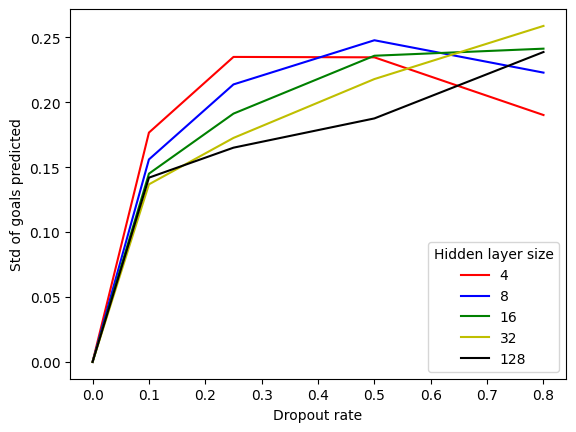

In [ ]:
if False:
    sizes = [4, 8, 16, 32, 128]
    dropout = [0, 0.1, 0.25, 0.5, 0.8]
    # expo = [True, False]

    df_s, df_d, df_e, df_std_h, df_std_a = [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]]
    df_train_loss, df_test_loss, df_train_acc, df_test_acc = [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]]
    # for s, d, e in itertools.product(sizes, dropout, expo):
    for i in range(1):
        for s, d in itertools.product(sizes, dropout):
            model = None
            df_s[i].append(s)
            df_d[i].append(d)
            # df_e.append(e)
            model = Sequential()
            model.add(InputLayer(14))
            model.add(Dropout(d))
            model.add(Dense(s, activation="relu"))
            # model.add(ControlledDropoutLayer(16, dch))
            model.add(Dense(2, activation="linear"))
            # if e:
            #     model.add(ExponentialLayer(2))

            # compile the keras model
            model.compile(loss=my_loss, optimizer="adam", metrics=my_acc)

            history = model.fit(X, y, epochs=50, batch_size=10)

            eval_loss, eval_acc = model.evaluate(X_test, y_test)

            df_train_loss[i].append(history.history["loss"][-1])
            df_train_acc[i].append(history.history["my_acc"][-1])
            df_test_loss[i].append(eval_loss)
            df_test_acc[i].append(eval_acc)

            preds = []
            for x in range(1000):
                preds.append(model(X_test, training=True))

            preds = np.stack(preds)
            # # preds = preds.astype(int)

            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

            home_std = np.std(predictions_home, axis=1)
            away_std = np.std(predictions_away, axis=1)

            df_std_h[i].append(home_std.mean())
            df_std_a[i].append(away_std.mean())
if True: # plot dropout std analysis
    auswertung = pd.read_csv("mlp_dropout_std.csv", sep=";")
    # plot auswertung
    fig, ax = plt.subplots(1)
    ax.plot(auswertung[auswertung["param_size"] == 4]["dropout"], auswertung[auswertung["param_size"] == 4]["std"], color="r", label="4")
    ax.plot(auswertung[auswertung["param_size"] == 8]["dropout"], auswertung[auswertung["param_size"] == 8]["std"], color="b", label="8")
    ax.plot(auswertung[auswertung["param_size"] == 16]["dropout"], auswertung[auswertung["param_size"] == 16]["std"], color="g", label="16")
    ax.plot(auswertung[auswertung["param_size"] == 32]["dropout"], auswertung[auswertung["param_size"] == 32]["std"], color="y", label="32")
    ax.plot(auswertung[auswertung["param_size"] == 128]["dropout"], auswertung[auswertung["param_size"] == 128]["std"], color="k", label="128")
    ax.set_ylabel("Std of goals predicted")
    ax.set_xlabel("Dropout rate")
    ax.legend(loc=4, title="Hidden layer size")
if False: # plot mlp size analysis
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    axs[0].plot(auswertung[auswertung["dropout"] == 0][["param_size"]], auswertung[auswertung["dropout"] == 0][["train_loss"]], "r-", label='Train Loss')
    axs[0].plot(auswertung[auswertung["dropout"] == 0][["param_size"]], auswertung[auswertung["dropout"] == 0][["test_loss"]], "r--", label="Test Loss")
    ax0_twin = axs[0].twinx()
    ax0_twin.plot(auswertung[auswertung["dropout"] == 0][["param_size"]], auswertung[auswertung["dropout"] == 0][["train_acc"]], "k-", label='Train Accuracy')
    ax0_twin.plot(auswertung[auswertung["dropout"] == 0][["param_size"]], auswertung[auswertung["dropout"] == 0][["test_acc"]], "k--", label="Test Accuracy")
    axs[0].set_xticks(auswertung[auswertung["dropout"] == 0][["param_size"]].values)
    axs[0].set_ylim([1,1.7])
    ax0_twin.set_ylim([0.5,0.65])
    axs[0].legend(loc=2)
    # ax0_twin.legend(loc=1)
    axs[1].plot(auswertung[auswertung["dropout"] == 0.25][["param_size"]], auswertung[auswertung["dropout"] == 0.25][["train_loss"]], "r-", label='Train Loss')
    axs[1].plot(auswertung[auswertung["dropout"] == 0.25][["param_size"]], auswertung[auswertung["dropout"] == 0.25][["test_loss"]], "r--", label="Test Loss")
    ax1_twin = axs[1].twinx()
    ax1_twin.plot(auswertung[auswertung["dropout"] == 0.25][["param_size"]], auswertung[auswertung["dropout"] == 0.25][["train_acc"]], "k-", label='Train Accuracy')
    ax1_twin.plot(auswertung[auswertung["dropout"] == 0.25][["param_size"]], auswertung[auswertung["dropout"] == 0.25][["test_acc"]], "k--", label="Test Accuracy")
    axs[1].set_xticks(auswertung[auswertung["dropout"] == 0.25][["param_size"]].values)
    axs[1].set_ylim([1,1.7])
    ax1_twin.set_ylim([0.5,0.65])
    #axs[1].legend(loc=2)
    #ax1_twin.legend(loc=1)
    axs[2].plot(auswertung[auswertung["dropout"] == 0.5][["param_size"]], auswertung[auswertung["dropout"] == 0.5][["train_loss"]], "r-", label='Train Loss')
    axs[2].plot(auswertung[auswertung["dropout"] == 0.5][["param_size"]], auswertung[auswertung["dropout"] == 0.5][["test_loss"]], "r--", label="Test Loss")
    ax2_twin = axs[2].twinx()
    ax2_twin.plot(auswertung[auswertung["dropout"] == 0.5][["param_size"]], auswertung[auswertung["dropout"] == 0.5][["train_acc"]], "k-", label='Train Accuracy')
    ax2_twin.plot(auswertung[auswertung["dropout"] == 0.5][["param_size"]], auswertung[auswertung["dropout"] == 0.5][["test_acc"]], "k--", label="Test Accuracy")
    axs[2].set_xticks(auswertung[auswertung["dropout"] == 0.5][["param_size"]].values)
    axs[2].set_ylim([1,1.7])
    ax2_twin.set_ylim([0.5,0.65])
    # axs[2].legend(loc=2)
    ax2_twin.legend(loc=1)
    axs[0].set_xscale("log")
    axs[1].set_xscale("log")
    axs[2].set_xscale("log")
    axs[0].set_xticks([4,8,16,32,128], ["4","8","16","32","128"])
    axs[1].set_xticks([4,8,16,32,128], ["4","8","16","32","128"])
    axs[2].set_xticks([4,8,16,32,128], ["4","8","16","32","128"])
    axs[1].set_yticks(np.arange(1,1.7,0.1),[])
    ax1_twin.set_yticks(np.arange(0.5,0.65,0.02),[])
    ax0_twin.set_yticks(np.arange(0.5,0.65,0.02),[])
    axs[2].set_yticks(np.arange(1,1.7,0.1),[])
    axs[0].set_title("Dropout=0.00")
    axs[1].set_title("Dropout=0.25")
    axs[2].set_title("Dropout=0.50")
    axs[0].set_yticks(np.arange(1,1.71,0.1),np.around(np.arange(1,1.71,0.1),2).astype(str),color="r")
    axs[0].set_ylabel("Loss", color="r")
    ax2_twin.set_ylabel("Accuracy")
    axs[0].set_xlabel("Hidden Layer Size")
    axs[1].set_xlabel("Hidden Layer Size")
    axs[2].set_xlabel("Hidden Layer Size")

# Controlled Dropout Evaluation Pipeline

In [ ]:
if False: # run cell or not
    run_params = []
    run_params.append(dropout_conf_1())
    run_params.append(dropout_conf_2())
    run_params.append(dropout_conf_3())
    dconf1, dconf2 = dropout_conf_1()
    tmp1, tmp2 = dropout_conf_2()
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_1()
    tmp1, tmp2 = dropout_conf_3()
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_2()
    tmp1, tmp2 = dropout_conf_3()
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_1()
    tmp1, tmp2 = dropout_conf_2()
    tmp3, tmp4 = dropout_conf_3()
    dconf1 = np.concatenate([dconf1, tmp1, tmp3])
    dconf2 = np.concatenate([dconf2, tmp2, tmp4])
    run_params.append((dconf1, dconf2))

    dropout_version_df, test_acc_df, std_df, ece_h_df, ece_d_df, ece_a_df = [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]], [[],[],[],[],[]]

    for i in range(5):
        for d_idx, (dconf1, dconf2) in enumerate(run_params):
            step_size = len(dconf1)
            dropout_version_df[i].append(d_idx)
            model = Sequential()
            model.add(InputLayer(14))
            model.add(ControlledDropoutLayer(dconf1))
            model.add(Dense(16, activation="relu"))
            model.add(ControlledDropoutLayer(dconf2))
            model.add(Dense(2, activation="linear"))
            # model.add(ExponentialLayer(2))

            model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
            hist = model.fit(X, y, epochs=100, steps_per_epoch=step_size, shuffle=True)

            preds = []
            for x in range(step_size):
                preds.append(model(X_test))

            preds = np.stack(preds)
            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
            home_std = np.std(predictions_home, axis=1)
            away_std = np.std(predictions_away, axis=1)

            std_df[i].append(((home_std.mean() + away_std.mean()) / 2))

            act_res = []
            for h, a in y_test:
                act_res.append(f"{str(int(h))}:{str(int(a))}")

            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

            game_quotes = []
            most_goals = {"home": [], "away": []}
            for game_idx in range(len(predictions_home)):
                game_df = pd.DataFrame(
                    {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
                )
                game_df["diff"] = game_df["home"] - game_df["away"]
                game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
                game_df["rounded_res"] = np.rint(game_df["clipped_res"])
                home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
                draw = (
                    game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
                )
                away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

                game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

            df_res = pd.DataFrame(
                {"actual": act_res, "predicted": game_quotes}
            ) 
            df_cross = pd.DataFrame(
                {
                    "actual": [
                        0
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        > int(df_res.iloc[i]["actual"].split(":")[1])
                        else 1
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        == int(df_res.iloc[i]["actual"].split(":")[1])
                        else 2
                        for i in range(df_res.shape[0])
                    ],
                    "pred": [
                        np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "pred_val": [
                        np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "bookie": [
                        np.argmax(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                    "bookie_val": [
                        np.max(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                }
            )
            right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
            home_pred = {"act_away": 0, "act_draw": 0}
            draw_pred = {"act_away": 0, "act_home": 0}
            away_pred = {"act_home": 0, "act_draw": 0}
            for x in range(df_cross.shape[0]):
                if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
                    if df_cross.iloc[x]["pred"] == 0:
                        if df_cross.iloc[x]["actual"] == 1:
                            home_pred["act_draw"] += 1
                        else:
                            home_pred["act_away"] += 1
                    elif df_cross.iloc[x]["pred"] == 1:
                        if df_cross.iloc[x]["actual"] == 0:
                            draw_pred["act_home"] += 1
                        else:
                            draw_pred["act_away"] += 1
                    else:
                        if df_cross.iloc[x]["actual"] == 0:
                            away_pred["act_home"] += 1
                        else:
                            away_pred["act_draw"] += 1
                    wrong += 1
                else:
                    if df_cross.iloc[x]["actual"] == 0:
                        home_right += 1
                    elif df_cross.iloc[x]["actual"] == 1:
                        draw_right += 1
                    else:
                        away_right += 1
                    right += 1

            home_wrong = home_pred["act_away"] + home_pred["act_draw"]
            draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
            away_wrong = away_pred["act_home"] + away_pred["act_draw"]
            acc = right / df_cross.shape[0]
            test_acc_df[i].append(acc)
            
            # ece
            data_length = df_cross.shape[0]
            acc_home = (
                df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
            acc_draw = (
                df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
            acc_away = (
                df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

            conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
            conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
            conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
            ece_h_df[i].append(abs(acc_home - conf_home))
            ece_d_df[i].append(abs(acc_draw - conf_draw))
            ece_a_df[i].append(abs(acc_away - conf_away))

    auswertung = pd.DataFrame({"dropout_conf": np.mean(dropout_version_df, axis=0), "test_acc": np.mean(test_acc_df, axis=0), "std": np.mean(std_df, axis=0), "ece_h": np.mean(ece_h_df, axis=0), "ece_d": np.mean(ece_d_df, axis=0), "ece_a": np.mean(ece_a_df, axis=0)})
    auswertung

# Feature Importance Pipeline

In [ ]:
if False:
    weights_list = []
    for _ in range(25):
        model = Sequential()
        model.add(Dense(16, input_shape=(14,), activation="relu"))
        # model.add(Dropout(0.5))
        model.add(Dense(2, activation="linear"))
        model.add(ExponentialLayer(2))

        model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
        hist = model.fit(X, y, epochs=25, batch_size=10)
        weights_list.append(abs(model.weights[0]))
    # vizualize the results
    swl = np.mean(weights_list, axis=0)
    swl = swl[:13]
    ax = sb.heatmap(abs(swl), cmap="Blues")
    ax.set_yticks(np.arange(0.5, 13.5, 1), labels=['Home xG',
                                                "Away xG", 
                                                "Home $\overline{xG}$",
                                                "Away $\overline{xG}$",
                                                "Home xT",
                                                "Away xT",
                                                "Home $\overline{xT}$",
                                                "Away $\overline{xT}$",
                                                "Form Home",
                                                "Form Away",
                                                "$\overline{Form Home}$",
                                                "$\overline{Form Away}$",
                                                "ELO Diff"],
                                                    rotation=0)
    ax.set_ylabel("Feature")
    ax.set_xlabel("Neuron")